In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import pandas as pd
import numpy as np
from bff_processor.data_tools import regex_select, get_files, make_df
from bff_processor.bff_meta import preselection, band_cut, isin, identity, all_reg, jet_variations
from bff_processor.bff_cuts import *

from glob import glob
import re

In [97]:
era = 2016
regex_select = ".+/tw_{}_(.+)\.csv".format(era)
files = [x for x in glob('data/*') if re.match(regex_select, x)]
DY = [x for x in files if re.match('.+ZTo(?:Mu|EE).+', x)]
ST = [x for x in files if re.match('.+top.csv', x)]
VB = [x for x in files if re.match('.+mc_(?:ww|wz|zz)', x)]
TT = [x for x in files if re.match('.+ttbar', x)]
BFF = [x for x in files if re.match('.+BFFZp', x)]
data = [x for x in files if re.match('.+_data_', x)]
assert len(files) == len(DY+ST+TT+VB+data+BFF), "duplicate or uncaught file"

In [98]:
sample_types = [
['.+ZTo(?:Mu|EE).+', 'bck'],
['.+top.csv', 'bck'],
['.+mc_(?:ww|wz|zz)', 'bck'],
['.+ttbar', 'bck'],
['.+BFFZp', 'sig'],
['.+_data_', 'data']
]

In [99]:
def process_file(file):
    name = re.findall(regex_select, file)[0]
    #get stuff for bff samples
    dbs = re.findall('dbs(\dp\d+)', name)
    mass = re.findall('_M_(\d+)', name)
    if len(dbs) == 1 : dbs = float(dbs[0].replace('p','.'))
    else: dbs = None
    if len(mass) == 1 : mass = int(mass[0])
    else: mass = None
    type_label = 0
    for re_sample, type_sample in sample_types:
        if re.match(re_sample, file): 
            type_label = type_sample
            break
            
    #open file and filter out events with bff selection
    df = preselection()(pd.read_csv(file))
    
    for reg in df.filter(regex='(?:SR|CR)\d+_.+'):
        nJets, jv = re.findall('(?:SR|CR)(\d)\d*_(.+)', reg)[0]
        # selected events are ==1, events pre bff selection are .5
        df[reg] = df[reg]*(1+bff_no_tmb_value[nJets](df, jv))/2
    selected_events = df.filter(regex='(?:SR|CR)\d+_.+').sum(axis=1)>0
    df['deltaR'] = df[["minGoodJetElDR","minGoodJetMuDR"]].min(axis=1)
    deltaR = df['deltaR'] > 0.4
    print( "{} remaining".format(   (df.filter(regex='(?:SR|CR)\d+_.+').sum(axis=1)>0).mean()))
    df = df[selected_events & deltaR]
    #remove unnamed column from index, probably a better way, but ok for now
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    #add metadata
    df['name'] = name
    df['dbs'] = dbs
    df['mass'] = mass
    df['type'] = type_label
    return df


In [107]:
combined_df = pd.DataFrame()
for file in files:
    print(file)
    df = process_file(file)
    combined_df = pd.concat([combined_df, df])
    break

data/tw_2016_mc_santitop.csv
1.0 remaining


In [108]:
np.unique(combined_df.CR10_nom)

array([0.    , 0.5   , 0.6875, 0.8125, 1.    ])

In [47]:
# convert to bool
combined_df['TriggerWeight'] = combined_df['TriggerWeight'].astype(bool)

In [48]:
import pyarrow.feather as feather
feather.write_feather(combined_df, 'data/combined_{}.feather'.format(era))

In [49]:
combined_df.to_parquet('data/combined_{}.parquet'.format(era))

In [50]:
import matplotlib.pyplot as plt

In [51]:
counts, bins  = np.histogram(combined_df[(combined_df.SR1_nom > 0) & (combined_df.type=='sig')].DiLepMass, bins=np.linspace(110,800,100))

In [52]:
counts_cut, bins  = np.histogram(combined_df[(combined_df.SR1_nom > .5) & (combined_df.type=='sig')].DiLepMass, bins=bins)

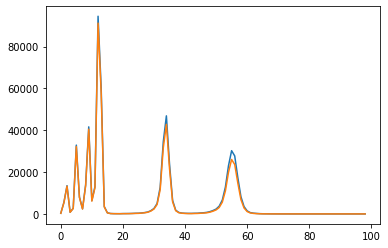

In [53]:
plt.plot(counts)
plt.plot(counts_cut)

In [54]:
bins

array([110.        , 116.96969697, 123.93939394, 130.90909091,
       137.87878788, 144.84848485, 151.81818182, 158.78787879,
       165.75757576, 172.72727273, 179.6969697 , 186.66666667,
       193.63636364, 200.60606061, 207.57575758, 214.54545455,
       221.51515152, 228.48484848, 235.45454545, 242.42424242,
       249.39393939, 256.36363636, 263.33333333, 270.3030303 ,
       277.27272727, 284.24242424, 291.21212121, 298.18181818,
       305.15151515, 312.12121212, 319.09090909, 326.06060606,
       333.03030303, 340.        , 346.96969697, 353.93939394,
       360.90909091, 367.87878788, 374.84848485, 381.81818182,
       388.78787879, 395.75757576, 402.72727273, 409.6969697 ,
       416.66666667, 423.63636364, 430.60606061, 437.57575758,
       444.54545455, 451.51515152, 458.48484848, 465.45454545,
       472.42424242, 479.39393939, 486.36363636, 493.33333333,
       500.3030303 , 507.27272727, 514.24242424, 521.21212121,
       528.18181818, 535.15151515, 542.12121212, 549.09

/tmp/ipykernel_1160/1318506214.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(counts_cut/counts)


(0.0, 1.0)

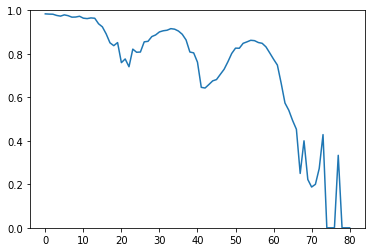

In [55]:
plt.plot(counts_cut/counts)
plt.ylim(top=1, bottom=0)